# Clients churn

Customers began to leave Beta Bank. Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We have been provided with historical data on customer behavior and termination of contracts with the bank.

It is necessary to build a model with an extremely large value of *F1*-measures. The target value of the metric = 0.59.


Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

According to the documentation provided, there is a transcript of the columns below.

- RowNumber — index of the row in the data
- CustomerID — unique identifier of the customer
- Surname — surname
- CreditScore — credit rating
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — how many years has a person been a customer of the bank
- Balance — account balance
- NumOfProducts — the number of bank products used by the customer
- HasCrCard — availability of a credit card
- IsActiveMember — client activity
- EstimatedSalary — estimated salary

Consider the information about the provided dataset.

## Data exploration

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings


In [2]:
warnings.simplefilter("ignore")
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

In [3]:
try:
    df = pd.read_csv('Churn.csv', index_col='RowNumber')
except:
    df = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')


df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


The missing values are in the Tenure column (how many years a person has been a customer of the bank). We will return to them later in addition.

Let's check for explicit duplicates in the dataset.

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Let's rename the columns and bring them to the lower case.

In [7]:
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()
df.index = df.index.rename('row_number')

df.head()

,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
row_number,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Let's check the rate of missing values in Tenure column.

In [8]:
df_tenure_isna = df['tenure'].isna().sum()/df['tenure'].count()
df_tenure_isna

0.0999890001099989

In [9]:
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [10]:
df['tenure'].value_counts()

tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

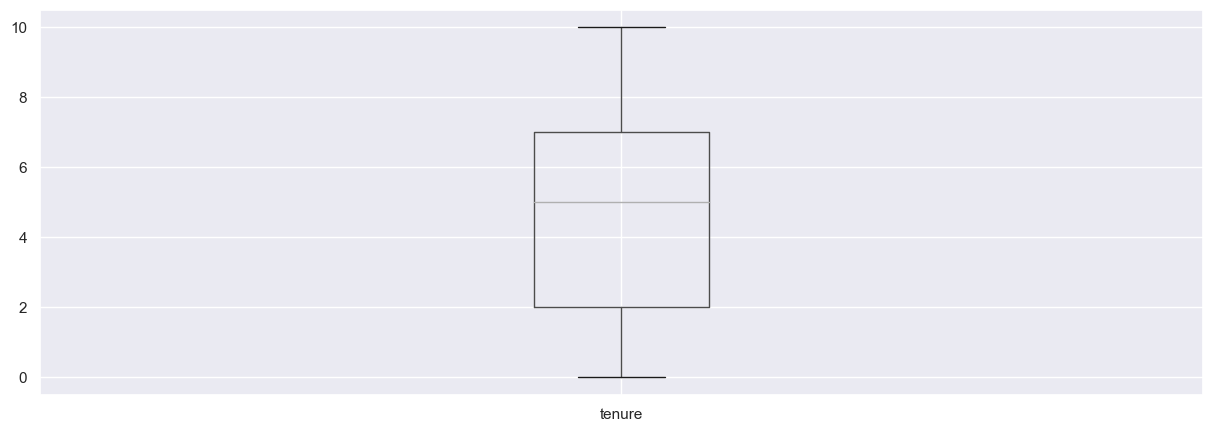

In [11]:
df.boxplot('tenure')
plt.show()

The omissions reach 10% of the entire dataset.
5 years is the median value. The bulk of the data is between 2 and 7 years old.
Therefore, in order not to lose important information, we will replace the omissions at this stage with the median value.

In [12]:
df['tenure'] = df['tenure'].fillna(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       10000 non-null  int64  
 1   surname          10000 non-null  object 
 2   creditscore      10000 non-null  int64  
 3   geography        10000 non-null  object 
 4   gender           10000 non-null  object 
 5   age              10000 non-null  int64  
 6   tenure           10000 non-null  float64
 7   balance          10000 non-null  float64
 8   numofproducts    10000 non-null  int64  
 9   hascrcard        10000 non-null  int64  
 10  isactivemember   10000 non-null  int64  
 11  estimatedsalary  10000 non-null  float64
 12  exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [13]:
df['tenure'] = df['tenure'].astype('int64')

***credit_score***

In [14]:
df['creditscore'].describe().to_frame()

,creditscore
count,10000.000000
mean,650.528800
std,96.653299
min,350.000000
25%,584.000000
50%,652.000000
75%,718.000000
max,850.000000


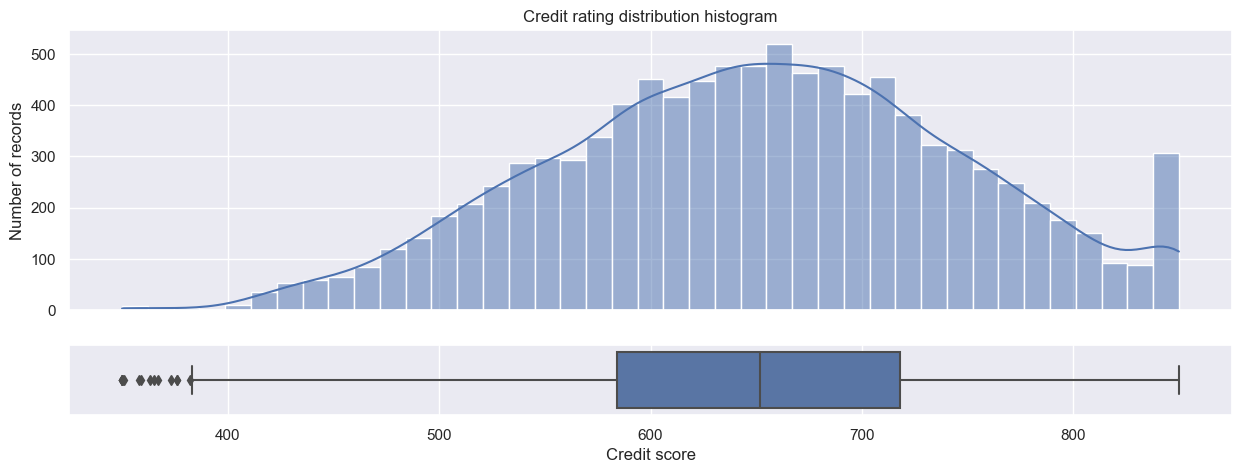

In [15]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='creditscore', kde=True, ax=axs_hist)\
.set(title='Credit rating distribution histogram',
     ylabel='Number of records')
sns.boxplot(data=df, x='creditscore', ax=axs_box)\
.set(xlabel='Credit score')
plt.show()

The credit rating values range from 350 to 850, the median value is 652, which is quite close to the average (650). The distribution looks like normal, but there is a fairly large number of entries with a credit rating of about 850.

***geography***

In [16]:
df['geography'].value_counts().to_frame()

,count
geography,
France,5014
Germany,2509
Spain,2477


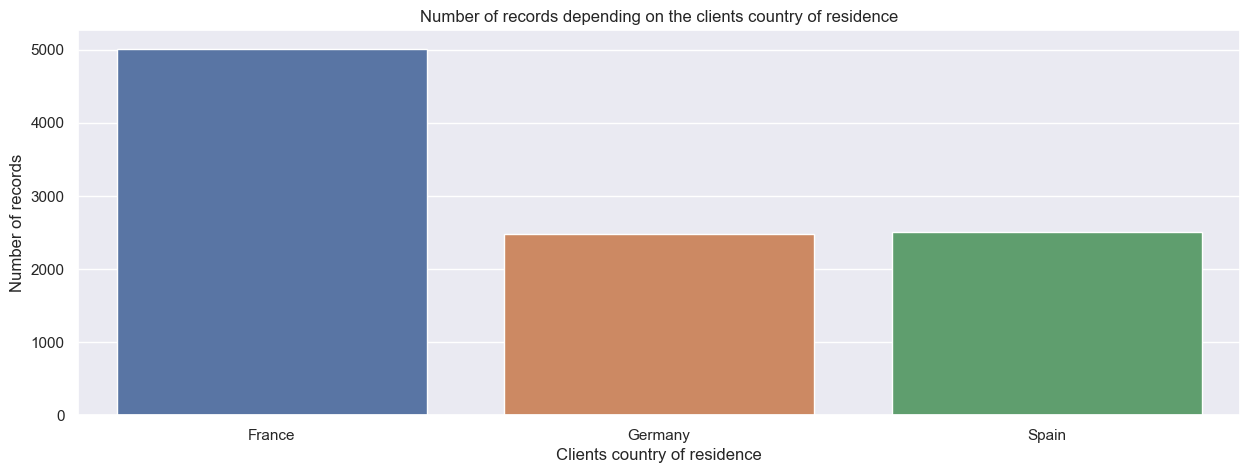

In [17]:
ax = sns.countplot(data=df, x='geography')
ax.set(xticklabels = (['France', 'Germany', 'Spain']))
plt.title('Number of records depending on the clients country of residence')
plt.xlabel('Clients country of residence')
plt.ylabel('Number of records')
plt.show()

It can be seen that the table shows data on customers from three countries: France, Spain and Germany. Most of the data about users from France.

***gender***

In [18]:
df['gender'].value_counts().to_frame()

,count
gender,
Male,5457
Female,4543


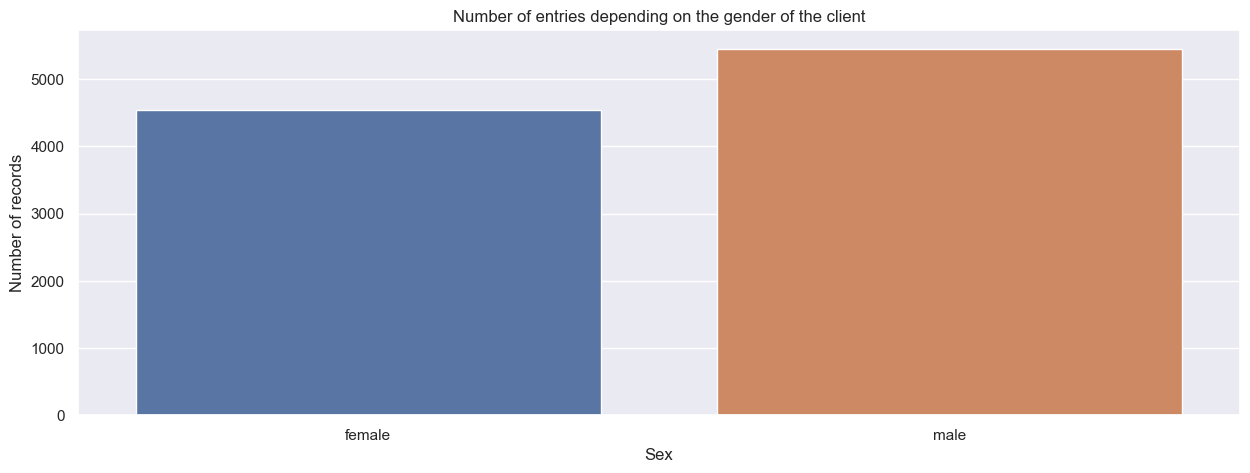

In [19]:
ax = sns.countplot(data=df, x='gender')
ax.set(xticklabels = (['female', 'male']))
plt.title('Number of entries depending on the gender of the client')
plt.xlabel('Sex')
plt.ylabel('Number of records')
plt.show()

***age***

In [20]:
df['age'].describe().to_frame()

,age
count,10000.000000
mean,38.921800
std,10.487806
min,18.000000
25%,32.000000
50%,37.000000
75%,44.000000
max,92.000000


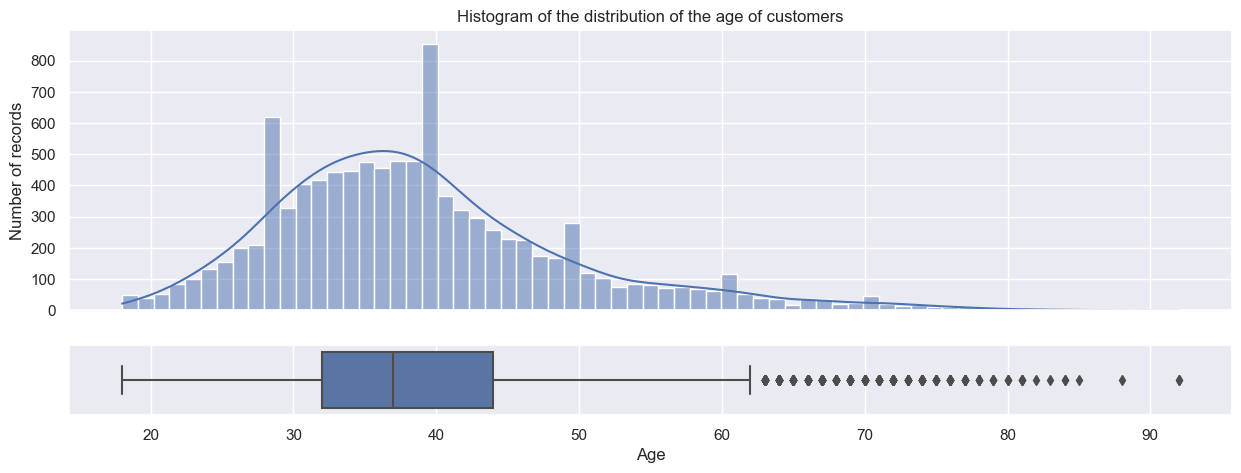

In [21]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='age', kde=True, ax=axs_hist)\
.set(title='Histogram of the distribution of the age of customers',
     ylabel='Number of records')
sns.boxplot(data=df, x='age', ax=axs_box)\
.set(xlabel='Age')
plt.show()

Age values of the clients range from 18 to 92 years, the median value is 37 years, which is quite close to the average (39 years). The distribution does not look like normal, there is a rather long right tail. The histogram shows suspicious "outliers" for the ages of 28, 40, 50, 60 years. Perhaps these are errors in the data, but it is quite difficult to make a reasoned assumption about the nature of their occurrence.

***tenure***

In [22]:
df['tenure'].describe().to_frame()

,tenure
count,10000.00000
mean,4.99790
std,2.76001
min,0.00000
25%,3.00000
50%,5.00000
75%,7.00000
max,10.00000


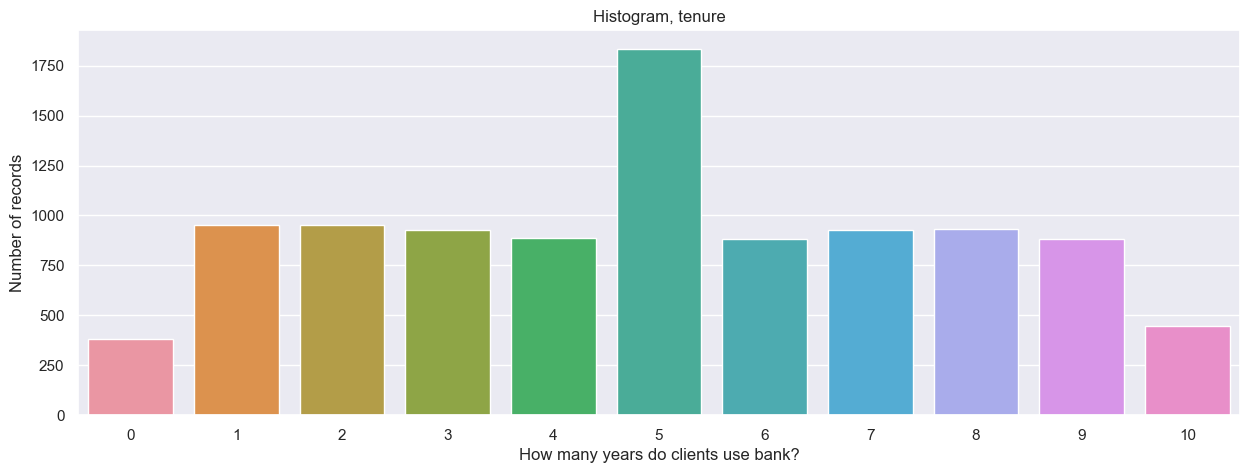

In [23]:
sns.countplot(data=df, x='tenure')\
.set(title='Histogram, tenure',
     xlabel='How many years do clients use bank?',
     ylabel='Number of records')
plt.show()

The values of the tenure parameter are in the range from 0 to 10 years, the median and average duration is 5 years. The graph shows the fashion for the value of 5 years.

***balance***

In [24]:
df['balance'].describe().to_frame()

,balance
count,10000.000000
mean,76485.889288
std,62397.405202
min,0.000000
25%,0.000000
50%,97198.540000
75%,127644.240000
max,250898.090000


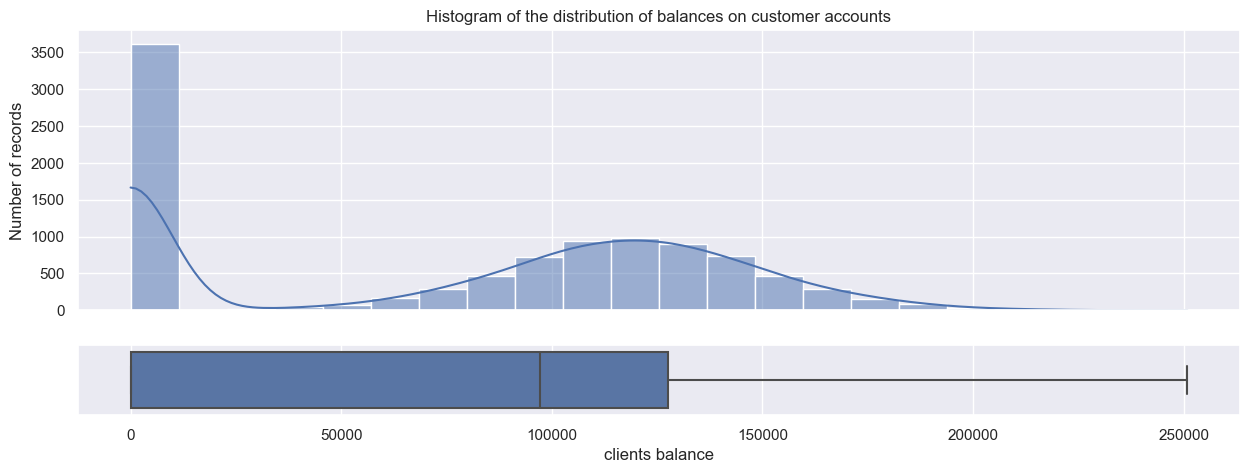

In [25]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='balance', kde=True, ax=axs_hist)\
.set(title='Histogram of the distribution of balances on customer accounts',
     ylabel='Number of records')
sns.boxplot(data=df, x='balance', ax=axs_box)\
.set(xlabel='clients balance')
plt.show()

The values of the balances on the accounts are in the range from 0 to 250 thousand, the median value is 97 thousand, the average is 76 thousand. The histogram shows that a significant number of customers have zero account balance.

***num_of_products***

In [26]:
df['numofproducts'].describe().to_frame()

,numofproducts
count,10000.000000
mean,1.530200
std,0.581654
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


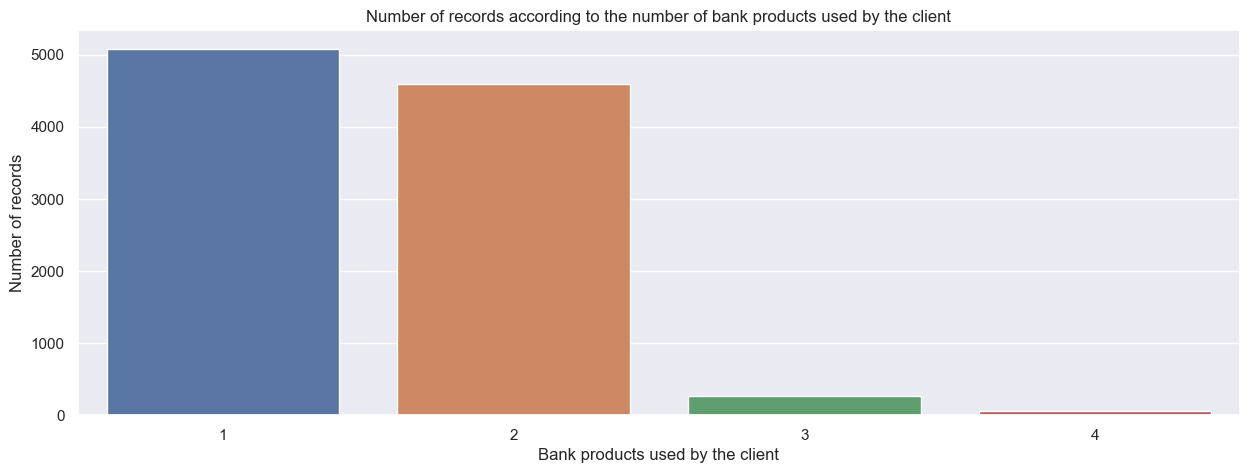

In [27]:
sns.countplot(data=df, x='numofproducts')
plt.title('Number of records according to the number of bank products used by the client')
plt.xlabel('Bank products used by the client')
plt.ylabel('Number of records')
plt.show()

Bank's customers use from 1 to 4 products of the bank. At the same time, the vast majority of customers use 1-2 products.

***has_cr_card***

In [28]:
df['hascrcard'].value_counts().to_frame()

,count
hascrcard,
1,7055
0,2945


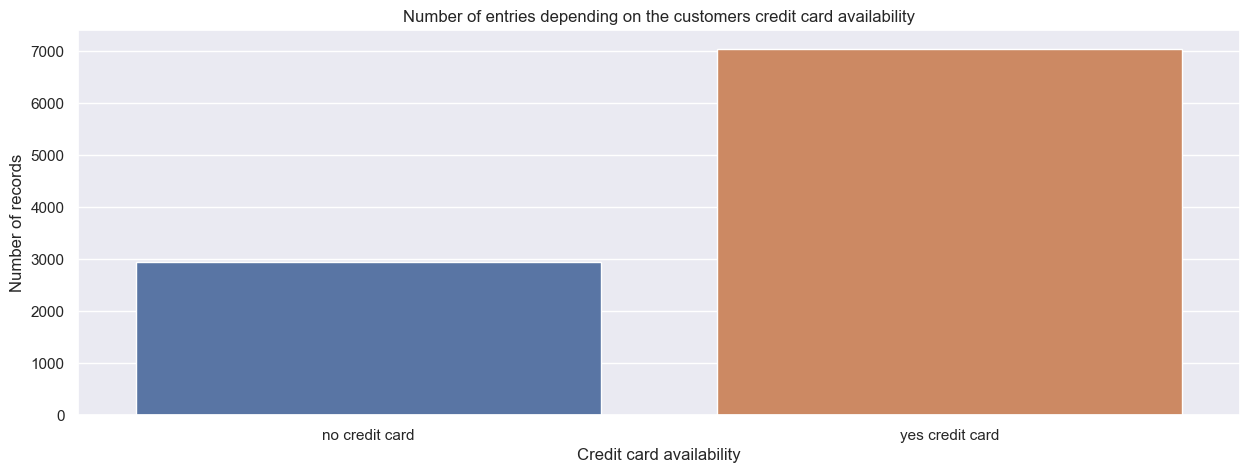

In [29]:
ax = sns.countplot(data=df, x='hascrcard')
ax.set(xticklabels = (['no credit card', 'yes credit card']))
plt.title('Number of entries depending on the customers credit card availability')
plt.xlabel('Credit card availability')
plt.ylabel('Number of records')
plt.show()

Most of the bank's customers have a credit card. This means that the lending service is very popular with the bank's customers.

***is_active_member***

In [30]:
df['isactivemember'].value_counts().to_frame()

,count
isactivemember,
1,5151
0,4849


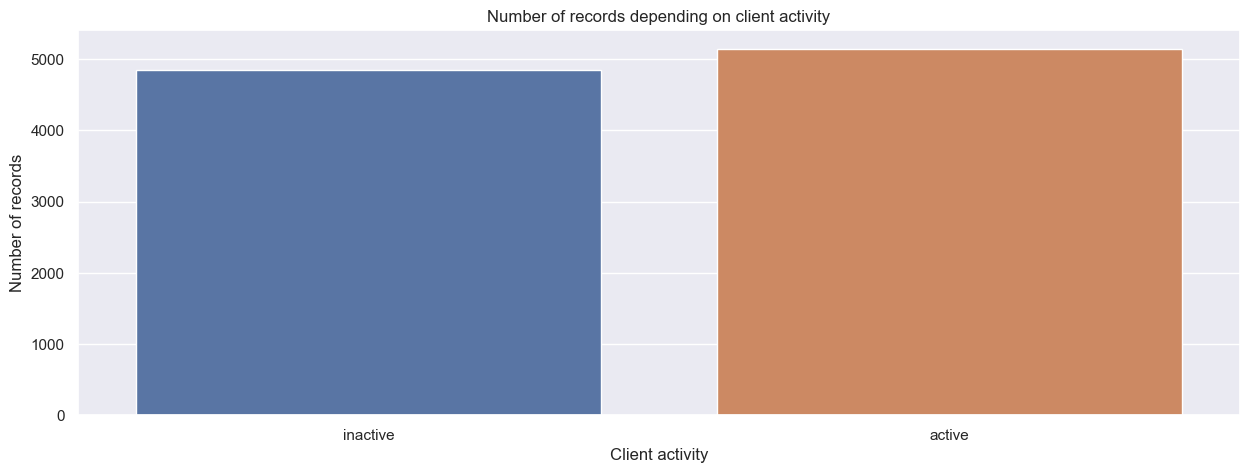

In [31]:
ax = sns.countplot(data=df, x='isactivemember')
ax.set(xticklabels = (['inactive', 'active']))
plt.title('Number of records depending on client activity')
plt.xlabel('Client activity')
plt.ylabel('Number of records')
plt.show()

The records of active and inactive clients of the bank are distributed approximately equally.

***estimated_salary***

In [32]:
df['estimatedsalary'].describe().to_frame()

,estimatedsalary
count,10000.000000
mean,100090.239881
std,57510.492818
min,11.580000
25%,51002.110000
50%,100193.915000
75%,149388.247500
max,199992.480000


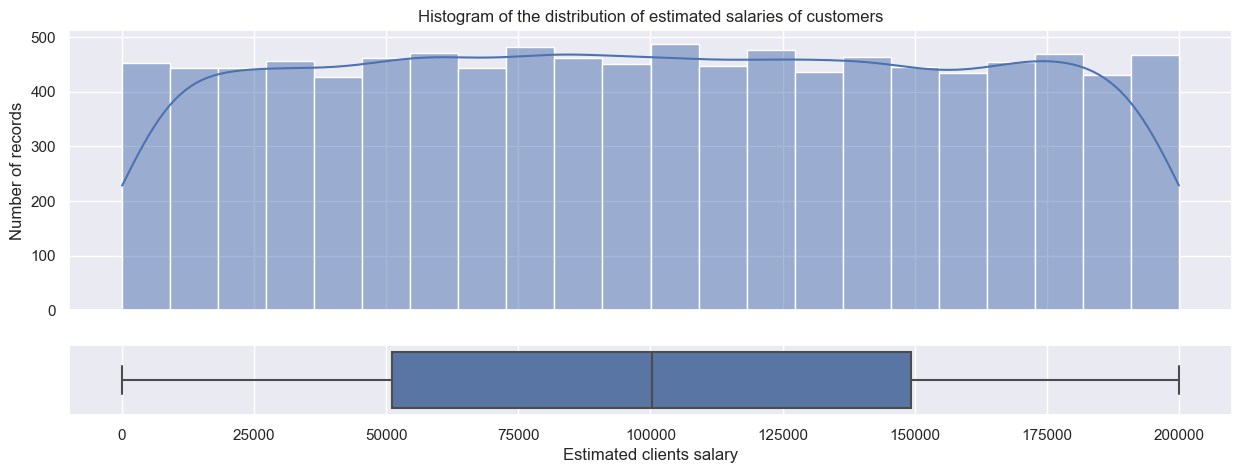

In [33]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='estimatedsalary', kde=True, ax=axs_hist)\
.set(title='Histogram of the distribution of estimated salaries of customers',
     ylabel='Number of records')
sns.boxplot(data=df, x='estimatedsalary', ax=axs_box)\
.set(xlabel='Estimated clients salary')
plt.show()

The values of the estimated of client's salaries are in the range from 12 to 200,000, the median value is 100 thousand, which is quite close to the average. At the same time, the distribution of estimated salaries looks implausible — the number of records practically does not depend on the estimated salary, although one could assume that the distribution will be more like a normal one. Perhaps this is due to some errors in the data, but additional research is required to test this hypothesis. We will also plot the dependence of the salary estimate on age. It can be assumed that young and elderly clients will have lower salaries than middle-aged clients.

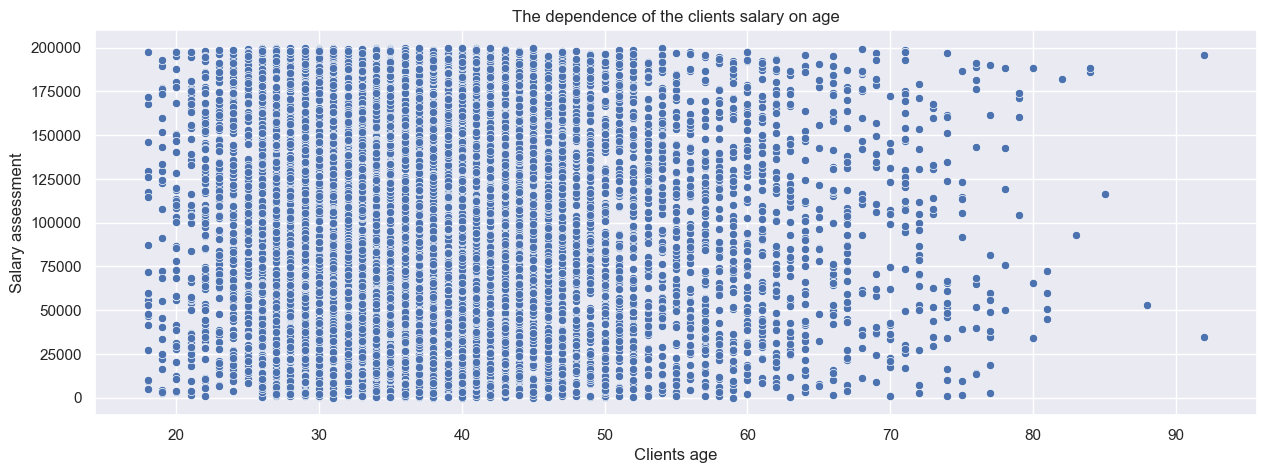

In [34]:
sns.scatterplot(data=df, y='estimatedsalary', x='age')
plt.title('The dependence of the clients salary on age')
plt.xlabel('Clients age')
plt.ylabel('Salary assessment')
plt.show()

There is no significant difference in the salary spread between clients aged 18, 40 and 70 on the chart, which is rather suspicious.

***exited***

In [35]:
df['exited'].value_counts().to_frame()

,count
exited,
0,7963
1,2037


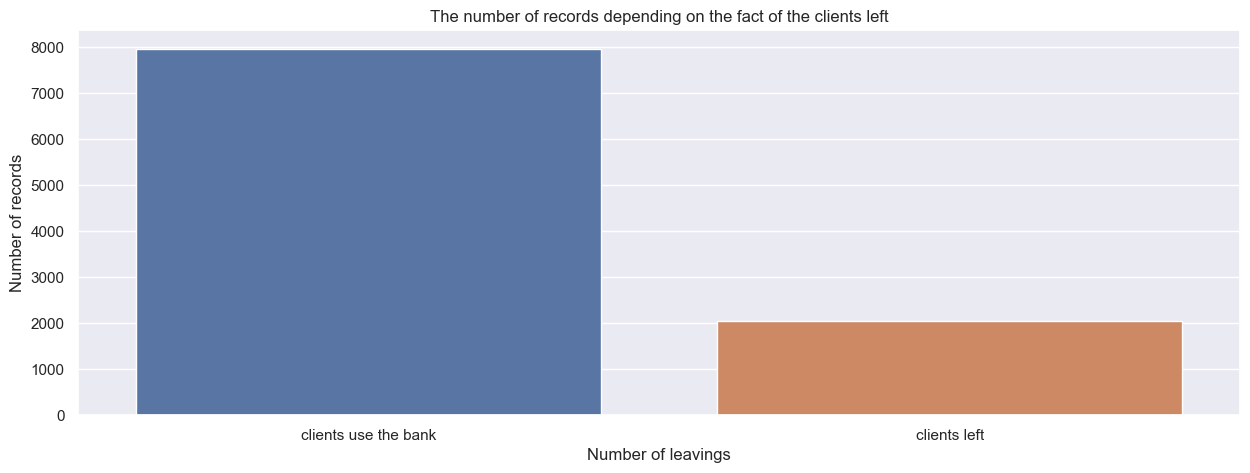

In [36]:
ax = sns.countplot(data=df, x='exited')
ax.set(xticklabels = (['clients use the bank', 'clients left']))
plt.title('The number of records depending on the fact of the clients left')
plt.xlabel('Number of leavings')
plt.ylabel('Number of records')
plt.show()

There is an imbalance of classes in our table — there is noticeably more data about customers remaining in the bank. This may be important when building models.

**Correlation check**

In [37]:
obj=['surname','geography','gender']
df_1 = df.drop(obj, axis=1)
df_1.corr()

,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
customerid,1.000000,0.005308,0.009497,-0.020331,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
creditscore,0.005308,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.009497,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.020331,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.025979,-0.030681,0.010049,-0.015989
balance,-0.012419,0.006268,0.028308,-0.007535,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numofproducts,0.016972,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hascrcard,-0.014025,-0.005458,-0.011721,0.025979,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isactivemember,0.001665,0.025651,0.085472,-0.030681,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedsalary,0.015271,-0.001384,-0.007201,0.010049,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.006248,-0.027094,0.285323,-0.015989,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


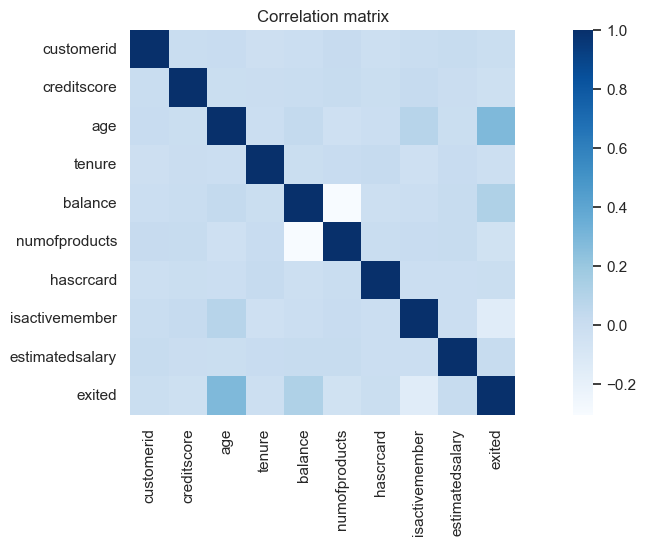

In [38]:
sns.heatmap(df_1.corr(), square=True, cmap='Blues')\
.set(title='Correlation matrix')
plt.show()

There is almost no correlation between the data in different columns.

The dataset contains columns whose contents are in the object format. In order to further correctly process the data, the ONE method will be applied.

The target feature for the forecast of customer outflow will be `exited`.

To begin with, we will remove unnecessary signs from the table: `surname`, `customerid`, `rownumber`. They will not help us in further research.

In [39]:
df = df.drop(["surname"], axis=1)
df = df.drop(["customerid"], axis=1)  


df = pd.get_dummies(df, drop_first=True)

df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
row_number,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
2,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
3,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
4,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
5,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [40]:
features = df.drop(['exited'], axis=1)
target = df['exited'] 


df_train, df_work = train_test_split(df, test_size=0.4, random_state=12345)


df_valid, df_test = train_test_split(df_work, test_size=0.5, random_state=12345)


features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']


numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])


features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

**Conlusion.** The information has been reviewed, missing values have been replaced with median ones, unnecessary features have been removed from the dataset. The target attribute and the others are highlighted, according to which we will prepare models according to the method of teaching with a teacher. Scaling of the features was also carried out.

## Research

**Class balance**: according to the results of checking the dataset, it is obvious that 80% of the target attribute Exited is "0" and 20% is "1". This imbalance is significant and may affect further research.

Next, let's look which of the models is best suited for predicting customer churn. At this stage, without taking into account the balance.

**1) Decision Tree.** We will determine the most optimal parameters without payind attention the balance and build a model.

In [41]:
model_dtc = DecisionTreeClassifier()
parametrs_dtc = {'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'min_samples_split': range (2, 6, 1)}
grid_dtc = GridSearchCV(model_dtc, parametrs_dtc, cv=5, scoring='f1')
grid_dtc.fit(features_train, target_train)

grid_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 3,
 'splitter': 'best'}

In [42]:
train_pred_basic_tree = grid_dtc.predict(features_train)
valid_pred_basic_tree = grid_dtc.predict(features_valid)

probabilities_train = grid_dtc.predict_proba(features_train)
probabilities_valid = grid_dtc.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

metric_names = ['accuracy_score','recall_score','precision_score','f1_score', 'roc_auc_score']
values_train = [accuracy_score(target_train, train_pred_basic_tree),
         recall_score(target_train, train_pred_basic_tree),
         precision_score(target_train, train_pred_basic_tree),
         f1_score(target_train, train_pred_basic_tree),
         roc_auc_score(target_train, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_basic_tree), 
               recall_score(target_valid, valid_pred_basic_tree),
               precision_score(target_valid, valid_pred_basic_tree),
               f1_score(target_valid, valid_pred_basic_tree),
               roc_auc_score(target_valid, probabilities_one_valid)]

results_train = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train.sort_values('metric_train',ascending=False)

,metric_train
accuracy_score,0.880833
roc_auc_score,0.880728
precision_score,0.848046
f1_score,0.621092
recall_score,0.489967


In [43]:
results_valid = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid.sort_values('metric_valid',ascending=False)

,metric_valid
accuracy_score,0.851500
roc_auc_score,0.816954
precision_score,0.773756
f1_score,0.535211
recall_score,0.409091


**2) Random forest** Let's determine the most optimal parameters without paying attention the balance and build a model.

In [44]:
%%time
model_rfc = RandomForestClassifier()

parametrs_rfc = {'n_estimators': range (10, 51, 10), 
                 'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split': range(2, 11)}
grid_rfc = GridSearchCV(model_rfc, parametrs_rfc, cv=5,scoring='f1')
grid_rfc.fit(features_train, target_train)

grid_rfc.best_params_

CPU times: user 7min 42s, sys: 1.31 s, total: 7min 43s
Wall time: 7min 43s


{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 10,
 'n_estimators': 40}

In [45]:
train_pred_rand_for = grid_rfc.predict(features_train)
valid_pred_rand_for = grid_rfc.predict(features_valid)

probabilities_train = grid_rfc.predict_proba(features_train)
probabilities_valid = grid_rfc.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]


values_train = [accuracy_score(target_train, train_pred_rand_for),
                recall_score(target_train, train_pred_rand_for),
                precision_score(target_train, train_pred_rand_for),
                f1_score(target_train, train_pred_rand_for),
                roc_auc_score(target_train, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_rand_for), 
                recall_score(target_valid, valid_pred_rand_for),
                precision_score(target_valid, valid_pred_rand_for),
                f1_score(target_valid, valid_pred_rand_for),
                roc_auc_score(target_valid, probabilities_one_valid)]

results_train = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train.sort_values('metric_train',ascending=False)

,metric_train
roc_auc_score,0.933044
precision_score,0.907012
accuracy_score,0.889667
f1_score,0.642549
recall_score,0.497492


In [46]:
results_valid = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid.sort_values('metric_valid',ascending=False)

,metric_valid
accuracy_score,0.860500
roc_auc_score,0.848106
precision_score,0.808889
f1_score,0.566096
recall_score,0.435407


**3) Logistic regression**. We will determine the most optimal parameters without taking into account the balance and build a model. let's iterate over the solver and max_iterations parameters.

In [47]:
%%time
model_log = LogisticRegression()

parametrs_log = {'max_iter': range (1000, 10000, 500), 
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_log = GridSearchCV(model_log, parametrs_log, cv=5, scoring='f1')
grid_log.fit(features_train, target_train)

grid_log.best_params_

CPU times: user 41.3 s, sys: 11.1 s, total: 52.4 s
Wall time: 5.42 s


{'max_iter': 1000, 'solver': 'newton-cg'}

In [48]:
train_pred_log = grid_log.predict(features_train)
valid_pred_log = grid_log.predict(features_valid)

probabilities_train = grid_log.predict_proba(features_train)
probabilities_valid = grid_log.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]


values_train = [accuracy_score(target_train, train_pred_log),
                recall_score(target_train, train_pred_log),
                precision_score(target_train, train_pred_log),
                f1_score(target_train, train_pred_log),
                roc_auc_score(target_train, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_log), 
                recall_score(target_valid, valid_pred_log),
                precision_score(target_valid, valid_pred_log),
                f1_score(target_valid, valid_pred_log),
                roc_auc_score(target_valid, probabilities_one_valid)]

results_train = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train.sort_values('metric_train',ascending=False)

,metric_train
accuracy_score,0.818667
roc_auc_score,0.777449
precision_score,0.616883
f1_score,0.343788
recall_score,0.238294


In [49]:
results_valid = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid.sort_values('metric_valid',ascending=False)

,metric_valid
accuracy_score,0.802000
roc_auc_score,0.758806
precision_score,0.563218
f1_score,0.331081
recall_score,0.234450


**Conclusion**

At the current stage of verification, the Random Forest model proved to be the best according to the F1 metric. At the same time, the decision tree model is slightly inferior to it.

The logistic regression model performed the worst

## Disbalance 

To combat the imbalance and choose the best model, consider 3 methods:
1) Add the 'class_weight' parameter to the models: 'balanced'.

2) We will conduct upsampling

3) We will conduct downsampling

**1) Add the 'class_weight' parameter to the models: 'balanced'.**

In [50]:
model_dtc = DecisionTreeClassifier()
parametrs_dtc = {'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'min_samples_split': range (2, 6, 1),
                'class_weight': ['balanced']}
grid_dtc = GridSearchCV(model_dtc, parametrs_dtc, cv=5, scoring='f1')
grid_dtc.fit(features_train, target_train)


train_pred_basic_tree = grid_dtc.predict(features_train)
valid_pred_basic_tree = grid_dtc.predict(features_valid)

probabilities_train = grid_dtc.predict_proba(features_train)
probabilities_valid = grid_dtc.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

values_train = [accuracy_score(target_train, train_pred_basic_tree),
         recall_score(target_train, train_pred_basic_tree),
         precision_score(target_train, train_pred_basic_tree),
         f1_score(target_train, train_pred_basic_tree),
         roc_auc_score(target_train, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_basic_tree), 
               recall_score(target_valid, valid_pred_basic_tree),
               precision_score(target_valid, valid_pred_basic_tree),
               f1_score(target_valid, valid_pred_basic_tree),
               roc_auc_score(target_valid, probabilities_one_valid)]

results_train = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train.sort_values('metric_train',ascending=False)

,metric_train
roc_auc_score,0.832645
accuracy_score,0.765500
recall_score,0.713211
f1_score,0.548024
precision_score,0.444966


In [51]:
results_valid = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid.sort_values('metric_valid',ascending=False)

,metric_valid
roc_auc_score,0.800583
accuracy_score,0.762000
recall_score,0.667464
f1_score,0.539652
precision_score,0.452922


In [52]:
model_rfc = RandomForestClassifier()

parametrs_rfc = {'n_estimators': range (10, 51, 10), 
                 'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split': range(2, 11),
                'class_weight': ['balanced']}
grid_rfc = GridSearchCV(model_rfc, parametrs_rfc, cv=5,scoring='f1')
grid_rfc.fit(features_train, target_train)

train_pred_rand_for = grid_rfc.predict(features_train)
valid_pred_rand_for = grid_rfc.predict(features_valid)

probabilities_train = grid_rfc.predict_proba(features_train)
probabilities_valid = grid_rfc.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]


values_train = [accuracy_score(target_train, train_pred_rand_for),
                recall_score(target_train, train_pred_rand_for),
                precision_score(target_train, train_pred_rand_for),
                f1_score(target_train, train_pred_rand_for),
                roc_auc_score(target_train, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_rand_for), 
                recall_score(target_valid, valid_pred_rand_for),
                precision_score(target_valid, valid_pred_rand_for),
                f1_score(target_valid, valid_pred_rand_for),
                roc_auc_score(target_valid, probabilities_one_valid)]

results_train = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train.sort_values('metric_train',ascending=False)

,metric_train
roc_auc_score,0.939629
accuracy_score,0.880667
recall_score,0.801003
f1_score,0.727964
precision_score,0.667131


In [53]:
results_valid = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid.sort_values('metric_valid',ascending=False)

,metric_valid
roc_auc_score,0.854174
accuracy_score,0.828500
recall_score,0.679426
f1_score,0.623491
precision_score,0.576065


In [54]:
model_log = LogisticRegression()

parametrs_log = {'max_iter': range (1000, 10000, 500), 
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'class_weight': ['balanced']}
grid_log = GridSearchCV(model_log, parametrs_log, cv=5, scoring='f1')
grid_log.fit(features_train, target_train)

grid_log.best_params_

train_pred_log = grid_log.predict(features_train)
valid_pred_log = grid_log.predict(features_valid)

probabilities_train = grid_log.predict_proba(features_train)
probabilities_valid = grid_log.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

values_train = [accuracy_score(target_train, train_pred_log),
                recall_score(target_train, train_pred_log),
                precision_score(target_train, train_pred_log),
                f1_score(target_train, train_pred_log),
                roc_auc_score(target_train, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_log), 
                recall_score(target_valid, valid_pred_log),
                precision_score(target_valid, valid_pred_log),
                f1_score(target_valid, valid_pred_log),
                roc_auc_score(target_valid, probabilities_one_valid)]

results_train = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train.sort_values('metric_train',ascending=False)

,metric_train
roc_auc_score,0.779896
accuracy_score,0.717167
recall_score,0.709030
f1_score,0.499853
precision_score,0.385981


In [55]:
results_valid = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid.sort_values('metric_valid',ascending=False)

,metric_valid
roc_auc_score,0.763684
accuracy_score,0.702000
recall_score,0.681818
f1_score,0.488851
precision_score,0.381016


**Conclusion** The F1 metric has improved significantly for all models. In Logistic Regression, the F1 metric has grown by almost 15%.
It should be noted that the Random Forest model has the highest F1 index.

**2)  upsampling**

In [56]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')


exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64


<Axes: xlabel='exited'>

Let's check the models

In [57]:
model_dtc_up = DecisionTreeClassifier()
parametrs_dtc_up = {'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'min_samples_split': range (2, 6, 1)
                }
grid_dtc_up = GridSearchCV(model_dtc_up, parametrs_dtc, cv=5, scoring='f1')

grid_dtc_up.fit(features_upsampled, target_upsampled)

train_pred_basic_tree = grid_dtc_up.predict(features_upsampled)
valid_pred_basic_tree = grid_dtc_up.predict(features_valid)

probabilities_train = grid_dtc_up.predict_proba(features_upsampled)
probabilities_valid = grid_dtc_up.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

values_train = [accuracy_score(target_upsampled, train_pred_basic_tree),
                recall_score(target_upsampled, train_pred_basic_tree),
                precision_score(target_upsampled, train_pred_basic_tree),
                f1_score(target_upsampled, train_pred_basic_tree),
                roc_auc_score(target_upsampled, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_basic_tree), 
                recall_score(target_valid, valid_pred_basic_tree),
                precision_score(target_valid, valid_pred_basic_tree),
                f1_score(target_valid, valid_pred_basic_tree),
                roc_auc_score(target_valid, probabilities_one_valid)]

results_train_up = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train_up.sort_values('metric_train',ascending=False)

,metric_train
roc_auc_score,0.932408
precision_score,0.847876
accuracy_score,0.847831
f1_score,0.847433
recall_score,0.846990


In [58]:
results_valid_up = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid_up.sort_values('metric_valid',ascending=False)

,metric_valid
accuracy_score,0.770000
roc_auc_score,0.767409
recall_score,0.648325
f1_score,0.540918
precision_score,0.464041


In [59]:
model_rfc_up = RandomForestClassifier()

parametrs_rfc_up = {'n_estimators': range (10, 51, 10), 
                 'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split': range(2, 11)
                }
grid_rfc_up = GridSearchCV(model_rfc_up, parametrs_rfc, cv=5,scoring='f1')

grid_rfc_up.fit(features_upsampled, target_upsampled)

train_pred_rand_for = grid_rfc_up.predict(features_upsampled)
valid_pred_rand_for = grid_rfc_up.predict(features_valid)
probabilities_train = grid_rfc_up.predict_proba(features_upsampled)
probabilities_valid = grid_rfc_up.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

values_train = [accuracy_score(target_upsampled, train_pred_rand_for),
                recall_score(target_upsampled, train_pred_rand_for),
                precision_score(target_upsampled, train_pred_rand_for),
                f1_score(target_upsampled, train_pred_rand_for),
                roc_auc_score(target_upsampled, probabilities_one_train)]

values_valid = [accuracy_score(target_valid, valid_pred_rand_for), 
                recall_score(target_valid, valid_pred_rand_for),
                precision_score(target_valid, valid_pred_rand_for),
                f1_score(target_valid, valid_pred_rand_for),
                roc_auc_score(target_valid, probabilities_one_valid)]

results_train_up = pd.DataFrame(data=values_train,index=metric_names,columns=['metric_train'])
results_train_up.sort_values('metric_train',ascending=False)

,metric_train
roc_auc_score,0.953906
precision_score,0.893027
accuracy_score,0.879641
f1_score,0.877260
recall_score,0.862040


In [60]:
results_valid_up = pd.DataFrame(data=values_valid,index=metric_names,columns=['metric_valid'])
results_valid_up.sort_values('metric_valid',ascending=False)

,metric_valid
roc_auc_score,0.853182
accuracy_score,0.817000
recall_score,0.681818
f1_score,0.608974
precision_score,0.550193


In [61]:
model_log_up = LogisticRegression()

parametrs_log_up = {'max_iter': range (1000, 10000, 500), 
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }
grid_log_up = GridSearchCV(model_log_up, parametrs_log_up, cv=5, scoring='f1')

grid_log_up.fit(features_upsampled, target_upsampled)

train_pred_log = grid_log_up.predict(features_upsampled)
valid_pred_log = grid_log_up.predict(features_valid)
probabilities_train = grid_log_up.predict_proba(features_upsampled)
probabilities_valid = grid_log_up.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

print("Train sample, accuracy:", accuracy_score(target_upsampled, train_pred_log))
print("Train sample, recall:", recall_score(target_upsampled, train_pred_log))
print("Train sample, precision:", precision_score(target_upsampled, train_pred_log))
print("Train sample, F-1:", f1_score(target_upsampled, train_pred_log))
print("Train sample, AUC-ROC:", roc_auc_score(target_upsampled, probabilities_one_train))
print()
print("Validation sample: accuracy", accuracy_score(target_valid, valid_pred_log))
print("Validation sample, recall:", recall_score(target_valid, valid_pred_log))
print("Validation sample, precision:", precision_score(target_valid, valid_pred_log))
print("Validation sample, F-1:", f1_score(target_valid, valid_pred_log))
print("Validation sample, AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

Train sample, accuracy: 0.714017521902378
Train sample, recall: 0.7073578595317725
Train sample, precision: 0.7160389335590351
Train sample, F-1: 0.7116719242902207
Train sample, AUC-ROC: 0.7798832981991038

Validation sample: accuracy 0.702
Validation sample, recall: 0.6818181818181818
Validation sample, precision: 0.3810160427807487
Validation sample, F-1: 0.4888507718696398
Validation sample, AUC-ROC: 0.7636221486943424


**Conclusion** F1-metric has also improved for all models. it is at the level with item 1.

**3) downsampling**

In [62]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64


<Axes: xlabel='exited'>

In [63]:
model_dtc_down = DecisionTreeClassifier()
parametrs_dtc_down = {'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'min_samples_split': range (2, 6, 1)
                }
grid_dtc_down = GridSearchCV(model_dtc_down, parametrs_dtc_down, cv=5, scoring='f1')

grid_dtc_down.fit(features_downsampled, target_downsampled)

train_pred_basic_tree = grid_dtc_down.predict(features_downsampled)
valid_pred_basic_tree = grid_dtc_down.predict(features_valid)
probabilities_train = grid_dtc_down.predict_proba(features_downsampled)
probabilities_valid = grid_dtc_down.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

print("Train sample, accuracy:", accuracy_score(target_downsampled, train_pred_basic_tree))
print("Train sample, recall:", recall_score(target_downsampled, train_pred_basic_tree))
print("Train sample, precision:", precision_score(target_downsampled, train_pred_basic_tree))
print("Train sample, F-1:", f1_score(target_downsampled, train_pred_basic_tree))
print("Train sample, AUC-ROC:", roc_auc_score(target_downsampled, probabilities_one_train))
print()
print("Validation score, accuracy:", accuracy_score(target_valid, valid_pred_basic_tree))
print("Validation score, recall:", recall_score(target_valid, valid_pred_basic_tree))
print("Validation score, precision:", precision_score(target_valid, valid_pred_basic_tree))
print("Validation score, F-1:", f1_score(target_valid, valid_pred_basic_tree))
print("ВValidation score, AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

Train sample, accuracy: 0.7893199833124739
Train sample, recall: 0.802675585284281
Train sample, precision: 0.7811228641171685
Train sample, F-1: 0.7917525773195877
Train sample, AUC-ROC: 0.8753550552911592

Validation score, accuracy: 0.75
Validation score, recall: 0.777511961722488
Validation score, precision: 0.44398907103825136
Validation score, F-1: 0.5652173913043478
ВValidation score, AUC-ROC: 0.8192456704915951


In [64]:
model_rfc_down = RandomForestClassifier()

parametrs_rfc_down = {'n_estimators': range (10, 51, 10), 
                 'max_depth': range (2, 10, 1),
                'criterion': ['gini', 'entropy', 'log_loss'],
                'min_samples_split': range(2, 11)
                }
grid_rfc_up = GridSearchCV(model_rfc_down, parametrs_rfc_down, cv=5,scoring='f1')

grid_rfc_up.fit(features_downsampled, target_downsampled)

train_pred_rand_for = grid_rfc_up.predict(features_downsampled)
valid_pred_rand_for = grid_rfc_up.predict(features_valid)
probabilities_train = grid_rfc_up.predict_proba(features_downsampled)
probabilities_valid = grid_rfc_up.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]


print("Train sample, accuracy:", accuracy_score(target_downsampled, train_pred_rand_for))
print("Train sample, recall:", recall_score(target_downsampled, train_pred_rand_for))
print("Train sample, precision:", precision_score(target_downsampled, train_pred_rand_for))
print("Train sample, F-1:", f1_score(target_downsampled, train_pred_rand_for))
print("Train sample, AUC-ROC:", roc_auc_score(target_downsampled, probabilities_one_train))
print()
print("Validation sample, accuracy:", accuracy_score(target_valid, valid_pred_rand_for))
print("Validation sample, recall:", recall_score(target_valid, valid_pred_rand_for))
print("Validation sample, precision:", precision_score(target_valid, valid_pred_rand_for))
print("Validation sample, F-1:", f1_score(target_valid, valid_pred_rand_for))
print("Validation sample, AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

Train sample, accuracy: 0.8560700876095119
Train sample, recall: 0.8235785953177257
Train sample, precision: 0.8802502234137622
Train sample, F-1: 0.8509719222462202
Train sample, AUC-ROC: 0.9402873580823116

Validation sample, accuracy: 0.784
Validation sample, recall: 0.7416267942583732
Validation sample, precision: 0.4889589905362776
Validation sample, F-1: 0.5893536121673003
Validation sample, AUC-ROC: 0.846018908897344


In [65]:
model_log_down = LogisticRegression()

parametrs_log_down = {'max_iter': range (1000, 10000, 500), 
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }
grid_log_down = GridSearchCV(model_log_down, parametrs_log_down, cv=5, scoring='f1')

grid_log_down.fit(features_downsampled, target_downsampled)

train_pred_log = grid_log_down.predict(features_downsampled)
valid_pred_log = grid_log_down.predict(features_valid)
probabilities_train = grid_log_down.predict_proba(features_downsampled)
probabilities_valid = grid_log_down.predict_proba(features_valid)
probabilities_one_train = probabilities_train[:, 1]
probabilities_one_valid = probabilities_valid[:, 1]

print("Train sample, accuracy:", accuracy_score(target_downsampled, train_pred_log))
print("Train sample, точность:", accuracy_score(target_downsampled, train_pred_log))
print("Train sample, recall:", recall_score(target_downsampled, train_pred_log))
print("Train sample, precision:", precision_score(target_downsampled, train_pred_log))
print("Train sample, F-1:", f1_score(target_downsampled, train_pred_log))
print("Train sample, AUC-ROC:", roc_auc_score(target_downsampled, probabilities_one_train))
print()
print("Validation sample, accuracy:", accuracy_score(target_valid, valid_pred_log))
print("Validation sample, recall:", recall_score(target_valid, valid_pred_log))
print("Validation sample, precision:", precision_score(target_valid, valid_pred_log))
print("Validation sample, F-1:", f1_score(target_valid, valid_pred_log))
print("Validation sample, AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

Train sample, accuracy: 0.7129745515227367
Train sample, точность: 0.7129745515227367
Train sample, recall: 0.7048494983277592
Train sample, precision: 0.7156196943972836
Train sample, F-1: 0.7101937657961247
Train sample, AUC-ROC: 0.7846861171988782

Validation sample, accuracy: 0.7005
Validation sample, recall: 0.6722488038277512
Validation sample, precision: 0.3781965006729475
Validation sample, F-1: 0.48406546080964685
Validation sample, AUC-ROC: 0.7622233379103431


**Conclusiom.** When unsampling, the F1 metric for all models decreased. unsampling won't do.

According to the obtained data, we select the random forest model with the class_weight = 'balanced' parameter as the most successful model

## Testing model

In [66]:
train_pred_rand_for = grid_rfc.predict(features_train)
test_pred_rand_for = grid_rfc.predict(features_test)

probabilities_test = grid_rfc.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

print("Обучающая выборка, точность:", accuracy_score(target_train, train_pred_rand_for))
print("Тестовая выборка, точность:", accuracy_score(target_test, test_pred_rand_for))
print("Тестовая выборка, recall:", recall_score(target_test, test_pred_rand_for))
print("Тестовая выборка, precision:", precision_score(target_test, test_pred_rand_for))
print("Тестовая выборка, F-1:", f1_score(target_test, test_pred_rand_for))
print("Тестовая выборка, AUC-ROC:", roc_auc_score(target_test, probabilities_one_valid))

Обучающая выборка, точность: 0.8806666666666667
Тестовая выборка, точность: 0.821
Тестовая выборка, recall: 0.6477541371158393
Тестовая выборка, precision: 0.567287784679089
Тестовая выборка, F-1: 0.6048565121412804
Тестовая выборка, AUC-ROC: 0.8492589244623137


## Results of the research

Based on the results of the analysis of the dataset for predicting the departure of customers from the bank, it was found out that the most suitable model for the study is a random forest model with the balanced parameter.

It gives the best indicators for F1-score (0.61, which is more than 0.59 according to the project condition).